# 🔥 Wildfire Growth Prediction: End-to-End Machine Learning Pipeline

**Project Overview**  
This notebook walks through the full process of predicting wildfire growth using a Random Forest model.  
We will cover:

1. Data loading and cleaning  
2. Creating a binary target variable  
3. Engineering relevant features  
4. Splitting into training/testing sets  
5. Building a preprocessing pipeline  
6. Training a Random Forest with hyperparameter tuning  
7. Evaluating model performance  
8. Saving the final trained pipeline  

By the end, we’ll have a production-ready machine learning model for wildfire growth prediction.

In [4]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib shap

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [6]:
# Load the fire training dataset
df = pd.read_csv("fire_training_data.csv")

# Basic shape and quick look
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Data shape: (1840, 19)

First 5 rows:
   brightness confidence satellite instrument  elevation  slope  \
0      328.04          n       N20      VIIRS       37.7   1.99   
1      306.71          n       N20      VIIRS       93.2   0.66   
2      325.99          n       N20      VIIRS      112.1   7.64   
3      331.94          n       N20      VIIRS      112.1   7.64   
4      326.85          n       N20      VIIRS      132.6   3.01   

  vegetationType    ndvi  landCover  treeCanopyPct  obs_count  mean_awnd  \
0      religious  0.5566         23            NaN         65   4.164308   
1        Unknown  0.5566         22           0.31         75   3.823733   
2        Unknown  0.5566         11            NaN         75   3.823733   
3        Unknown  0.5566         11            NaN         75   3.823733   
4        Unknown  0.5566         21           0.13         75   3.823733   

   max_awnd  total_prcp  max_prcp  mean_tmax  max_tmax  mean_tmin  min_tmin  
0     19.24         0.0 


Missing values (%):
treeCanopyPct     21.956522
elevation          3.206522
slope              3.206522
vegetationType     3.206522
dtype: float64

Summary Statistics:
         brightness confidence satellite instrument    elevation        slope  \
count   1840.000000       1840      1840       1840  1781.000000  1781.000000   
unique          NaN          3         1          1          NaN          NaN   
top             NaN          n       N20      VIIRS          NaN          NaN   
freq            NaN       1614      1840       1840          NaN          NaN   
mean     330.013766        NaN       NaN        NaN   443.027737     3.595957   
std       23.074064        NaN       NaN        NaN   345.490988     2.208167   
min      207.930000        NaN       NaN        NaN    33.900000     0.000000   
25%      308.180000        NaN       NaN        NaN   132.600000     1.990000   
50%      332.055000        NaN       NaN        NaN   449.900000     3.590000   
75%      349.205000  

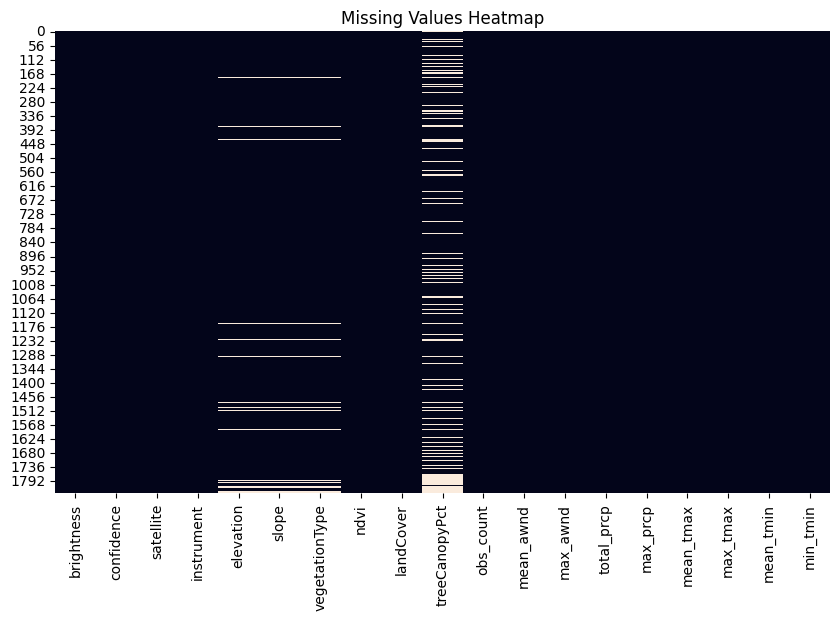

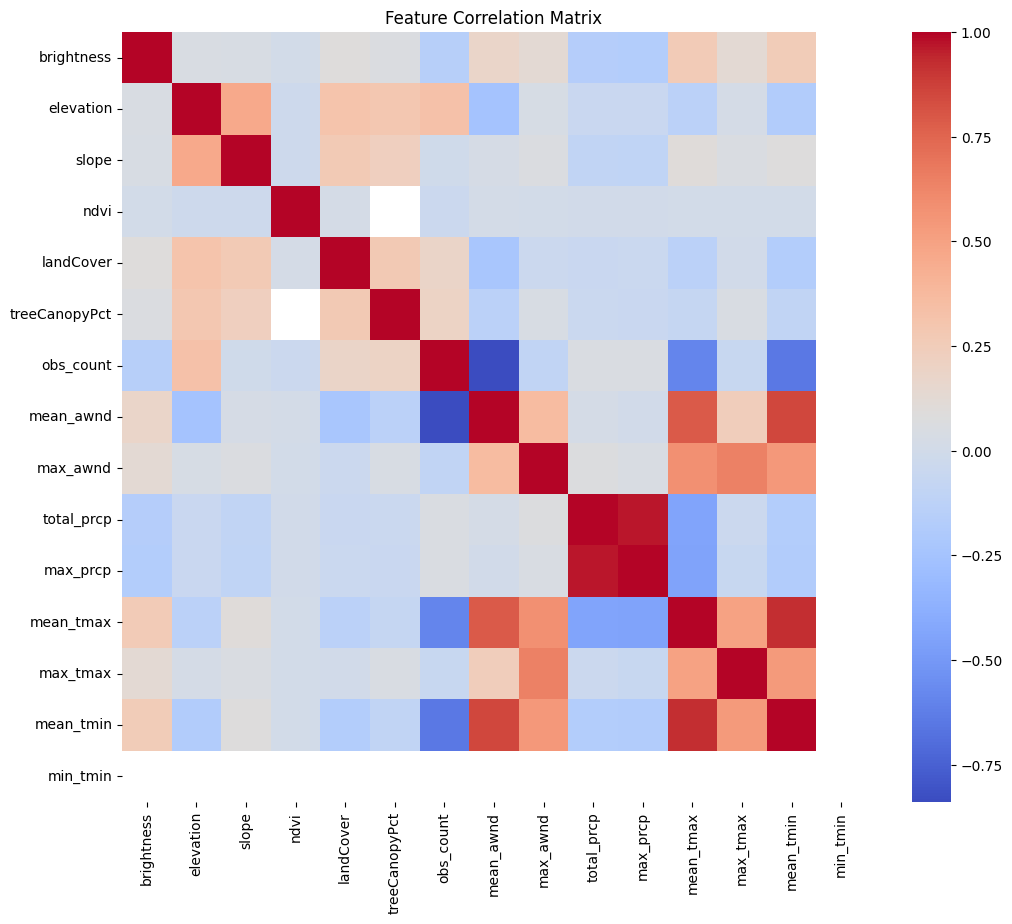

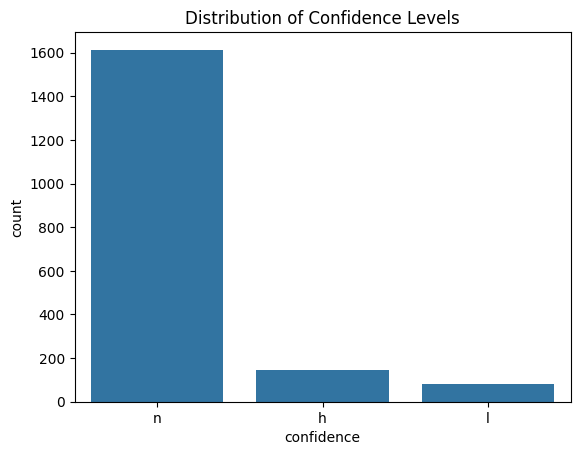

In [7]:
# ==================================================================
# STEP 2: DATA EXPLORATION & ANALYSIS
# ==================================================================

# Check missing values
print("\nMissing values (%):")
missing_percentage = df.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Basic stats
print("\nSummary Statistics:")
print(df.describe(include='all'))

# Data types
print("\nData Types:")
print(df.dtypes.value_counts())

# Target distribution
print("\nTarget distribution (confidence):")
print(df['confidence'].value_counts())

# Visualize missing data
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Correlation matrix (for numeric variables)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Distribution of target
sns.countplot(x='confidence', data=df, order=df['confidence'].value_counts().index)
plt.title('Distribution of Confidence Levels')
plt.show()

In [8]:
# ==================================================================
# STEP 3: PREPROCESSING
# ==================================================================

# Drop columns with too many missing values (>50%)
df = df.drop(columns=['treeCanopyPct'])  # Already identified

# Split into features and target
X = df.drop('confidence', axis=1)
y = df['confidence']

# Encode target labels (Low, Medium, High)
le = LabelEncoder()
y = le.fit_transform(y)  # Encoded as 0, 1, 2

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical and numerical columns
categorical_features = ['vegetationType', 'satellite', 'instrument']
numerical_features = [col for col in X.columns if col not in categorical_features]

print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Build preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])


Categorical Features: ['vegetationType', 'satellite', 'instrument']
Numerical Features: ['brightness', 'elevation', 'slope', 'ndvi', 'landCover', 'obs_count', 'mean_awnd', 'max_awnd', 'total_prcp', 'max_prcp', 'mean_tmax', 'max_tmax', 'mean_tmin', 'min_tmin']


In [9]:
# ==================================================================
# STEP 4: MODEL BUILDING & HYPERPARAMETER TUNING
# ==================================================================

# Create full pipeline with preprocessing + classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set hyperparameter search space
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
}

# GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, verbose=2, n_jobs=-2)
grid_search.fit(X_train, y_train)

Fitting 20 folds for each of 4 candidates, totalling 80 fits
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['brightness',
                                                                          'elevation',
                                                                          'slope',
                                                                          'ndvi',
                                                                          'landCover',
                                                                          'obs_count',
                                                                          'mean_awnd',
                                                                          'max_awnd',
                                                                          'total_prcp',
                                                                          'max_prcp',
                                                                          'mean_tmax',
                                                                          'max_tmax',
                                                                          'mean_tmin',
                                                                          'min_tmin']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['vegetationType',
                                                                          'satellite',
                                                                          'instrument'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'classifier__max_depth': [None, 10],
                         'classifier__n_estimators': [100, 200]},
             verbose=2)


Best Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           h       0.76      0.90      0.83        29
           l       0.33      0.12      0.18        16
           n       0.98      1.00      0.99       323

    accuracy                           0.95       368
   macro avg       0.69      0.67      0.67       368
weighted avg       0.94      0.95      0.94       368



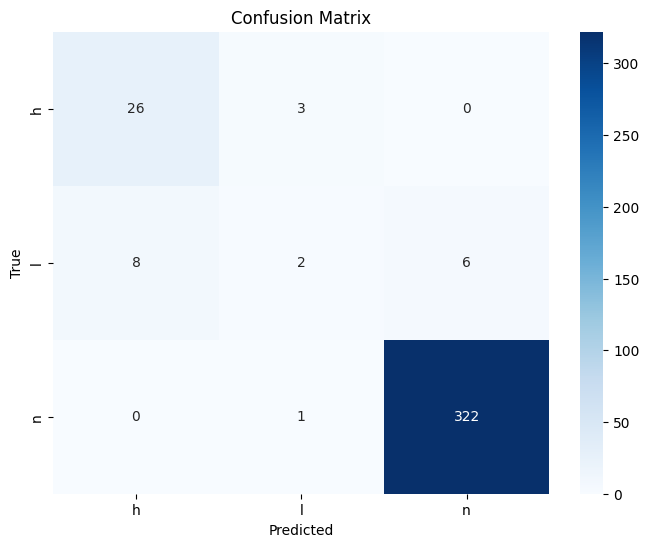

In [10]:
# ==================================================================
# STEP 5: MODEL EVALUATION
# ==================================================================

# Best model after tuning
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Accuracy
print(f"\nBest Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

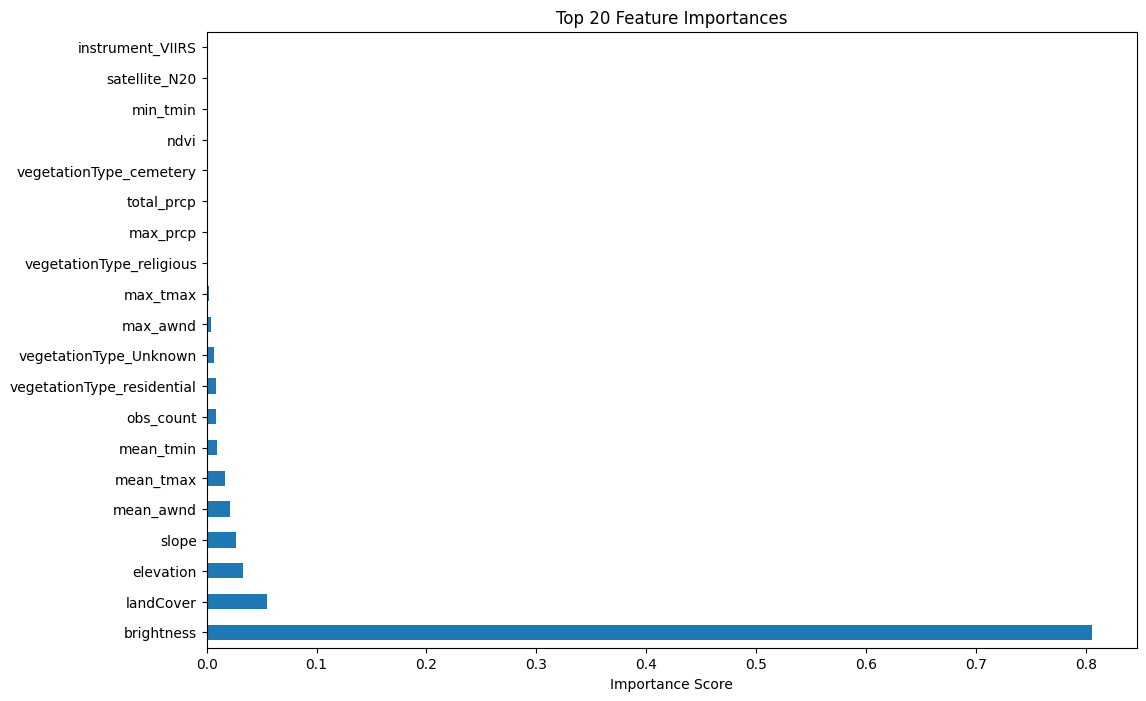

In [11]:
# ==================================================================
# STEP 6: FEATURE IMPORTANCE
# ==================================================================

# Retrieve feature names after preprocessing
feature_names = numerical_features + list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_features)
)

# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Plot top 20 features
plt.figure(figsize=(12,8))
pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20].plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [12]:
# ==================================================================
# STEP 7: SAVE MODEL
# ==================================================================

# Save the best trained model
joblib.dump(best_model, 'fire_detection_model.pkl')
print("Model saved as fire_detection_model.pkl!")

Model saved as fire_detection_model.pkl!


In [13]:
# ==================================================================
# IMPORT LIBRARIES
# ==================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Save model
import joblib

In [14]:
# ==================================================================
# STEP 1: LOAD DATA
# ==================================================================

# Load the dataset
df = pd.read_csv("fire_training_data.csv")

print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1840, 19)

First 5 rows:
   brightness confidence satellite instrument  elevation  slope  \
0      328.04          n       N20      VIIRS       37.7   1.99   
1      306.71          n       N20      VIIRS       93.2   0.66   
2      325.99          n       N20      VIIRS      112.1   7.64   
3      331.94          n       N20      VIIRS      112.1   7.64   
4      326.85          n       N20      VIIRS      132.6   3.01   

  vegetationType    ndvi  landCover  treeCanopyPct  obs_count  mean_awnd  \
0      religious  0.5566         23            NaN         65   4.164308   
1        Unknown  0.5566         22           0.31         75   3.823733   
2        Unknown  0.5566         11            NaN         75   3.823733   
3        Unknown  0.5566         11            NaN         75   3.823733   
4        Unknown  0.5566         21           0.13         75   3.823733   

   max_awnd  total_prcp  max_prcp  mean_tmax  max_tmax  mean_tmin  min_tmin  
0     19.24         0

In [15]:
# ==================================================================
# STEP 2: DATA CLEANING
# ==================================================================

# Fix missing values: fill missing 'treeCanopyPct' with median
df['treeCanopyPct'] = df['treeCanopyPct'].fillna(df['treeCanopyPct'].median())

# Drop redundant columns
df = df.drop(columns=['satellite', 'instrument'])  # Constant features

print("\nRemaining Columns After Cleaning:", df.columns.tolist())


Remaining Columns After Cleaning: ['brightness', 'confidence', 'elevation', 'slope', 'vegetationType', 'ndvi', 'landCover', 'treeCanopyPct', 'obs_count', 'mean_awnd', 'max_awnd', 'total_prcp', 'max_prcp', 'mean_tmax', 'max_tmax', 'mean_tmin', 'min_tmin']


In [16]:
# ==================================================================
# STEP 3: PREPROCESSING SETUP
# ==================================================================

# Convert target to categorical
df['confidence'] = df['confidence'].astype('category')

# Split features and target
X = df.drop('confidence', axis=1)
y = df['confidence']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify feature types
categorical_features = ['vegetationType']
numerical_features = [col for col in X.columns if col not in categorical_features]

print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['vegetationType']
Numerical Features: ['brightness', 'elevation', 'slope', 'ndvi', 'landCover', 'treeCanopyPct', 'obs_count', 'mean_awnd', 'max_awnd', 'total_prcp', 'max_prcp', 'mean_tmax', 'max_tmax', 'mean_tmin', 'min_tmin']


In [17]:
# ==================================================================
# STEP 4: PIPELINE CREATION
# ==================================================================

# Preprocessing steps
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

# Full pipeline: preprocessing + model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # Handle imbalance
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [None, 15, 20],
    'classifier__min_samples_split': [2, 5]
}

# Grid Search CV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

In [18]:
# ==================================================================
# STEP 5: MODEL TRAINING
# ==================================================================

# Train the model with Grid Search
grid_search.fit(X_train, y_train)

# Best model after hyperparameter search
best_model = grid_search.best_estimator_

print(f"\nBest Parameters Found: {grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters Found: {'classifier__max_depth': 15, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}



Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           h       0.74      0.90      0.81        29
           l       0.25      0.06      0.10        16
           n       0.98      1.00      0.99       323

    accuracy                           0.95       368
   macro avg       0.66      0.65      0.63       368
weighted avg       0.93      0.95      0.94       368



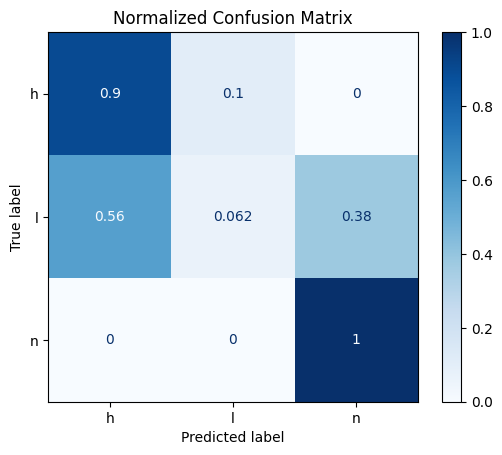

In [19]:
# ==================================================================
# STEP 6: MODEL EVALUATION
# ==================================================================

# Predict on test set
y_pred = best_model.predict(X_test)

# Accuracy score
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Normalized confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize='true', cmap='Blues'
)
plt.title("Normalized Confusion Matrix")
plt.show()

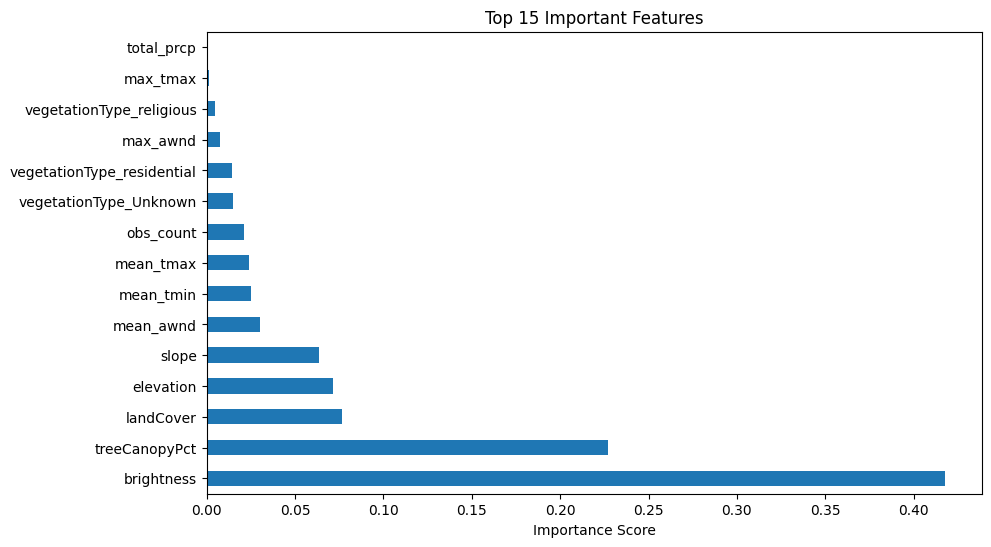

In [20]:
# ==================================================================
# STEP 7: FEATURE IMPORTANCE
# ==================================================================

# Retrieve feature names after preprocessing
feature_names = numerical_features + list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Plot top 15 important features
plt.figure(figsize=(10,6))
pd.Series(importances, index=feature_names)\
    .sort_values(ascending=False)[:15]\
    .plot(kind='barh')
plt.title("Top 15 Important Features")
plt.xlabel("Importance Score")
plt.show()

In [21]:
# ==================================================================
# STEP 8: SAVE MODEL
# ==================================================================

# Save the best trained model
joblib.dump(best_model, 'fire_detection_model.pkl')
print("Model saved successfully as 'fire_detection_model.pkl'!")

Model saved successfully as 'fire_detection_model.pkl'!
